# Tutorial 2: Test on simulated data 

In [1]:
from dlim.model import DLIM 
from dlim.dataset import Data_model
from dlim.api import DLIM_API
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from numpy.random import choice
from src_simulate_data.sim_data import Simulated

## Load data 
**1. type_f** 

the type of landscape: 
- bio: biomechanistic model from Kemble, Harry, et al. "Flux, toxicity, and expression costs generate complex genetic interactions in a metabolic pathway." Science Advances 6.23 (2020): eabb2236.

- add:
\begin{equation*}
 X + Y
\end{equation*}
- quad: 
\begin{equation*}
 X\times Y
\end{equation*}
- comp: 
\begin{equation*}
X+Y - X\times Y
\end{equation*}
- saddle: 
\begin{equation*}
X^2 - Y^2
\end{equation*}

- hat:
\begin{equation*}
sin(X^2 + Y^2)
\end{equation*}

- exp: 
\begin{equation*}
exp^{\frac{(X-\hat{X})^2 + (Y-\hat{Y})^2}{\sigma}}
\end{equation*}

- tgaus: see Materials and methods 

- cascade: see Materials and methods 

**2. nb_var** 

number of mutations in each gene (two genes in total)

**3. Load data** 

- step1: change data into dataframe, where the first two columns are mutations, the last column is fitness 

- step 2: use Data_Model to change data into tensor format for training 

In [2]:
type_f = "cascade" 
nb_var = 30
data_simulated = Simulated(nb_var, type_f)
data = Data_model(data=pd.DataFrame(data_simulated.data), n_variables=2)
model_save_path = 'pretrain/simulate_' + str(type_f) + '_model.pt'

/home/swang/project/flux_project/dlim_v2/D-LIM-model-v2/src_simulate_data/sim_data.py:12: RuntimeWarning: invalid value encountered in power
  return ((M-m)/(1 + power(x/K, n))) + m


## Split data into 70% for training and 30% for testing 

In [3]:

train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.7), replace=False)
val_id = [i for i in range(data.data.shape[0]) if i not in train_id]
train_data = data.subset(train_id)
val_data = data.subset(val_id)

## Construct DLIM model and API
- step 1: use DLIM to define model, e.g., number of neurons in each layer and number of layers
- step 2: DLIM_API to feed model, and flag_spectral to determine if spectral initialization will be used 
- step 3: dlim_regressor.fit to train model, define 

### Hyperparameters

- lr: learning rate
- nb_epoch: number of epoches 
- batch_size: size of batch
- emb_regularization: weight on regularization on embeddings 
- save_path: path for saveing model, if None, the model won't be saved 

In [4]:
model = DLIM(n_variables = train_data.nb_val, hid_dim = 32, nb_layer = 0)
dlim_regressor = DLIM_API(model=model, flag_spectral=True)
losses = dlim_regressor.fit(train_data, lr = 1e-3, nb_epoch=300, batch_size=32, emb_regularization=0, \
                            save_path= model_save_path)

spectral gap = 0.7145543098449707
spectral gap = 0.33826231956481934
Model saved to pretrain/simulate_cascade_model.pt


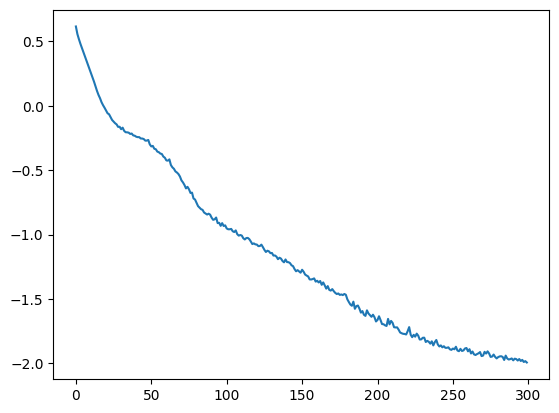

In [5]:
plt.figure 
plt.plot(losses)
plt.show()##

## Predict on validation data 

In [6]:
fit_a, var_a, lat_a = dlim_regressor.predict(val_data.data[:,:-1], detach=True) 

## Visualization 
- first panel: the landscape of the simulated data & the sampled data for model testing 
- second panel: the landscape by DLIM
- third panel: the infered phenotype of each mutations on gene 1 versus all fitness mesured on this mutation
- forth panel: the infered phenotype of each mutations on gene 2 versus all fitness mesured on this mutation

0.9941104694956487
PearsonRResult(statistic=-0.08332610904660781, pvalue=0.17218686572539452)


/home/swang/project/flux_project/dlim_v2/D-LIM-model-v2/src_simulate_data/sim_data.py:12: RuntimeWarning: invalid value encountered in power
  return ((M-m)/(1 + power(x/K, n))) + m


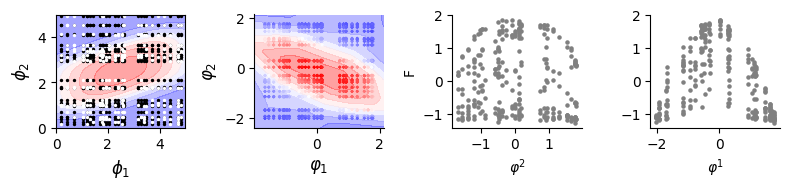

In [7]:
score = pearsonr(fit_a.flatten(), val_data.data[:, [-1]].flatten())[0]
print(score)

fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(8, 2))
data_simulated.plot(ax)
ax.scatter(data_simulated.A[data_simulated.data[train_id, 0].int()], data_simulated.B[data_simulated.data[train_id, 1].int()], s=2, marker="o", c="black")
ax.scatter(data_simulated.A[data_simulated.data[val_id, 0].int()], data_simulated.B[data_simulated.data[val_id, 1].int()], s=2, marker="o", c="white")
dlim_regressor.plot(bx, data)

for xx in [bx, cx, dx]:
    for el in ["top", "right"]:
        xx.spines[el].set_visible(False)

# Plot the a00verage curve
print(pearsonr(lat_a[:, 0], val_data[:, -1]))
cx.scatter(lat_a[:, 0], val_data[:, -1], s=5, c="grey")
dx.scatter(lat_a[:, 1], val_data[:, -1], s=5, c="grey")
cx.set_ylabel("F")
dx.set_xlabel("$\\varphi^1$")
cx.set_xlabel("$\\varphi^2$")
plt.tight_layout()
plt.show()

## Relationship between predicted phenotype and real 

Text(0.3, 0.8, '$\\rho=-1.0$')

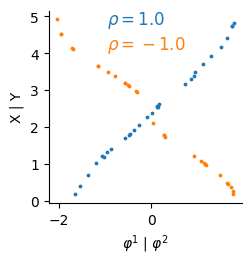

In [8]:
fig, ax = plt.subplots(1, figsize=(2.5, 2.5))
score_A = spearmanr(model.genes_emb[0].detach(), data_simulated.A)[0]
score_B = spearmanr(model.genes_emb[1].detach(), data_simulated.B)[0]
ax.scatter(model.genes_emb[0].detach(), data_simulated.A, c="C0", s=3)
ax.scatter(model.genes_emb[1].detach(), data_simulated.B, c="C1", s=3)
ax.set_xlabel("$\\varphi^1$ | $\\varphi^2$")
ax.set_ylabel("X | Y")
for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
ax.annotate(f"$\\rho={score_A:.1f}$", xy=(0.3, 0.93), xycoords="axes fraction", fontsize=12, c="C0")
ax.annotate(f"$\\rho={score_B:.1f}$", xy=(0.3, 0.8), xycoords="axes fraction", fontsize=12, c="C1")

## Use pretrained model 

In [9]:
model = DLIM(n_variables = data.nb_val, hid_dim = 32, nb_layer = 0)
dlim_regressor = DLIM_API(model=model, flag_spectral=True, load_model=model_save_path)
fit_a, var_a, lat_a = dlim_regressor.predict(data.data[:,:-1], detach=True) 

0.9946422443738447
PearsonRResult(statistic=-0.014091019784485452, pvalue=0.6729052788855285)


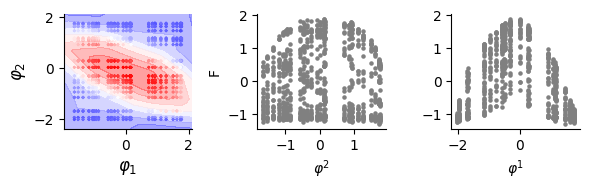

In [10]:
score = pearsonr(fit_a.flatten(), data.data[:, [-1]].flatten())[0]
print(score)

fig, (bx, cx, dx) = plt.subplots(1, 3, figsize=(6, 2))
dlim_regressor.plot(bx, data)

for xx in [bx, cx, dx]:
    for el in ["top", "right"]:
        xx.spines[el].set_visible(False)

# Plot the a00verage curve
print(pearsonr(lat_a[:, 0], data[:, -1]))
cx.scatter(lat_a[:, 0], data[:, -1], s=5, c="grey")
dx.scatter(lat_a[:, 1], data[:, -1], s=5, c="grey")
cx.set_ylabel("F")
dx.set_xlabel("$\\varphi^1$")
cx.set_xlabel("$\\varphi^2$")
plt.tight_layout()
plt.show()